# Pre-processing & Modeling

* __Pre-processing: read the image in DCM format and convert them to PNG format__

* __Bulid and train a Image Classification__
  - There are four classes:
  
        1. Typical Appearance: Multifocal bilateral, peripheral opacities with rounded morphology, lower lung–predominant distribution

        2. Indeterminate Appearance: Absence of typical findings AND unilateral, central or upper lung predominant distribution

        3. Atypical Appearance: Pneumothorax, pleural effusion, pulmonary edema, lobar consolidation, solitary lung nodule or mass, diffuse tiny nodules, cavity

        4. Negative for Pneumonia: No lung opacities


## 1 Installs and Imports 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -c conda-forge gdcm -y


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 8.8MB/s 


In [ ]:
import os
import math 
import pandas as pd
import numpy as np
import seaborn as sns
#import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,Activation
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models  
from sklearn.metrics import confusion_matrix,classification_report

## 2 Loading the Data

In [ ]:
path = '../input/covid19-detection-datawrangling-eda/data_information.csv'
data_info_df = pd.read_csv(path)
data_info_df.head()

,boxes,label,StudyInstanceUID,image_path,study_id,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,num_boxes,class_name
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-detection/train/5776db0c...,5776db0cec75_study,000a312787f2_image,0,1,0,0,2,Typical Appearance
1,[],none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-detection/train/ff0879eb...,ff0879eb20ed_study,000c3a3f293f_image,1,0,0,0,0,Negative for Pneumonia
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-detection/train/9d514ce4...,9d514ce429a7_study,0012ff7358bc_image,0,1,0,0,2,Typical Appearance
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-detection/train/28dddc85...,28dddc8559b2_study,001398f4ff4f_image,0,0,0,1,1,Atypical Appearance
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-detection/train/dfd9fdd8...,dfd9fdd85a3e_study,001bd15d1891_image,0,1,0,0,2,Typical Appearance


## 3 Pre-processing

### 3.1 Create the Function for Reading and Rescaling the Dcm Image 

In [ ]:
def read_dcm_image(image_info):
    """
    This function is used to read the dcm image
    
    image_info: dictionary that includes the image id  
                image path
    return:
    numpy array of the image pixels in range 0-255
    """
    img = pydicom.dcmread(image_info['image_path'])
    arr = img.pixel_array
    arr = arr - np.min(arr)
    arr = arr / np.max(arr)
    arr = (arr * 255).astype(np.uint8)   
    
    return arr

### 3.2 Plot the Distribution Of the original and rescaled imamge

(array([2451.,   80.,   64.,   25.,   29.,   32.,   40.,   59.,   56.,
          47.,   40.,   61.,   39.,   84.,  119.,  167.,  245.,  443.,
         132.,   35.]),
 array([   0.  ,  204.75,  409.5 ,  614.25,  819.  , 1023.75, 1228.5 ,
        1433.25, 1638.  , 1842.75, 2047.5 , 2252.25, 2457.  , 2661.75,
        2866.5 , 3071.25, 3276.  , 3480.75, 3685.5 , 3890.25, 4095.  ]),
 <BarContainer object of 20 artists>)

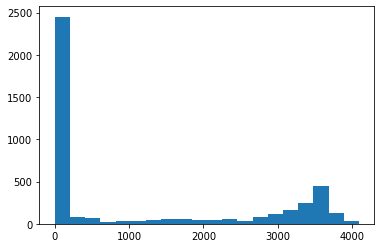

In [ ]:
# before rescale
im_origin = pydicom.dcmread(data_info_df.image_path[10]).pixel_array
plt.hist(im_origin[0], bins=20)

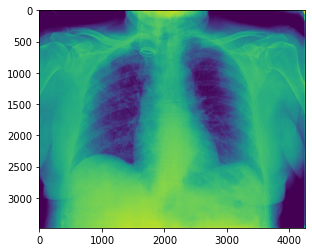

In [ ]:
# show the original image
plt.imshow(im_origin)

(array([[1176.,   65.,   36., ...,    0.,    0.,    0.],
        [1172.,   69.,   37., ...,    0.,    0.,    0.],
        [1176.,   60.,   39., ...,    0.,    0.,    0.],
        ...,
        [   5.,   30.,   74., ...,   88.,   86.,  306.],
        [   0.,    0.,    0., ...,  260.,  622., 2195.],
        [   0.,    0.,    0., ...,    9.,   39., 3432.]]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <a list of 4248 BarContainer objects>)

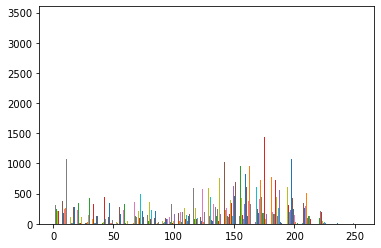

In [ ]:
# after rescale
im_resacal = read_dcm_image(data_info_df.loc[10,:])
plt.hist(im_resacal, bins=20)

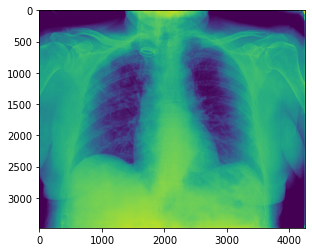

In [ ]:
#show the images after rescale
plt.imshow(im_resacal)

### 3.3 Rescale All the Image and Save Them to PNG Format

In [ ]:
image_id = []
image_path = []
image_class = []

save_dir = './train/'

os.makedirs(save_dir, exist_ok=True)

for i in range(len(data_info_df)):
    # set keep_ratio=True to have original aspect ratio
    item = data_info_df.loc[i,:]
    save_path = os.path.join(save_dir, item['image_id']+'.png')
    rescale_im = read_dcm_image(item)
    image_id.append(item['image_id'])
    image_class.append(item['class_name'])
    image_path.append(save_path)
    im = Image.fromarray(rescale_im)
    im.save(save_path)

In [ ]:
# Create a data frame containing the information of the images

rescaled_image_info = pd.DataFrame({'image_id':image_id,'image_path': image_path, 'image_class':image_class})
rescaled_image_info.head()
rescaled_image_info.to_csv('./rescaled_image_info.csv',index=False)

In [ ]:
rescaled_image_info.shape

## 4 Get the Rescaled Image Data

### 4.1 Read the CSV File From to Get the Rescaled Image Path and the Image Class

In [ ]:
img_info_df_path = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/data/rescaled_image_info.csv'
subpath = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/data/train'
img_info = pd.read_csv(img_info_df_path)
img_info['image_path'] = img_info['image_path'].str.replace('./train', subpath)
img_info.head()

,image_id,image_path,image_class
0,000a312787f2_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Typical Appearance
1,000c3a3f293f_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Negative for Pneumonia
2,0012ff7358bc_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Typical Appearance
3,001398f4ff4f_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Atypical Appearance
4,001bd15d1891_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Typical Appearance


### 4.2 Split the DataFrame to Train and Test Set

In [ ]:
train, test = train_test_split(img_info, test_size=0.2, random_state=42, shuffle=True)
train = train.reset_index()
test = test.reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

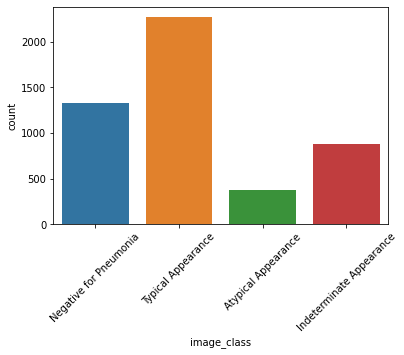

In [ ]:
sns.countplot(train.image_class)
plt.xticks(rotation=45)

In [ ]:
train.shape

(4843, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

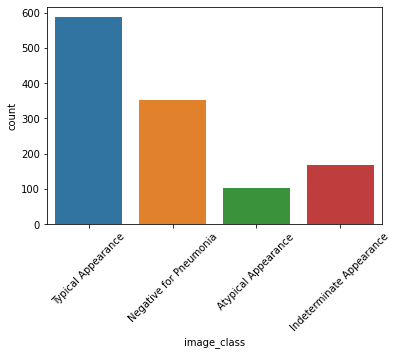

In [ ]:
sns.countplot(test.image_class)
plt.xticks(rotation=45)

In [ ]:
test.shape

(1211, 4)

## 5 Vgg16 Model 

### 5.1 Create the Image Data Generator for Training and Test Set

* Apply image augmentation to train set. Note: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have. So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [ ]:
batch_size = 64

# rescale each pixel into range [0,1]
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_set = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image_path',
    y_col='image_class',
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    #subset='training',
    seed=1)

validation_set = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='image_class', 
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    #subset='validation',
    seed=1)

Found 4843 validated image filenames belonging to 4 classes.
Found 1211 validated image filenames belonging to 4 classes.


In [ ]:
train_set[0][0].shape

(64, 224, 224, 1)

* Batch size is 64 for training set, each image with size 224\*224\*1

### 5.2 Build the Non Pretrained Vgg16 Model 

In [ ]:
input_shape = (224,224,1)
vgg16 =VGG16(include_top=False,
             input_shape = input_shape,
             pooling = 'avg', # can be 'avg' or 'max'
             weights=None  # set weight to None beaause I am not using the pretrain model
             ) 
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Adding some layers to the end of the Vgg16 model

model1 = Sequential([
    vgg16,
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),
    Flatten(),
    Dense(4,activation='softmax')
    ])

model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14713536  
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

### 5.3 Train the Vgg16 Model

In [ ]:
model1.compile(
    optimizer = optimizers.Adam(learning_rate=0.00001), 
    loss = 'categorical_crossentropy',               
    metrics=[AUC(name = 'auc'), 'accuracy'])

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/'

callback = ModelCheckpoint(filepath=checkpoint_filepath + 'best_vgg16.hdf5',
                           save_weights_only=True,
                           monitor='val_auc',
                           mode='max',
                           save_best_only=True)
history = model1.fit(train_set, 
                    validation_data = validation_set, 
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    validation_steps=validation_set.n//validation_set.batch_size,
                    epochs = 130,
                    callbacks=[callback])

Epoch 1/130
75/75 [==============================] - 259s 3s/step - loss: 1.3870 - auc: 0.5254 - accuracy: 0.2796 - val_loss: 1.3827 - val_auc: 0.6586 - val_accuracy: 0.4878
Epoch 2/130
75/75 [==============================] - 255s 3s/step - loss: 1.3582 - auc: 0.5886 - accuracy: 0.3725 - val_loss: 1.3800 - val_auc: 0.6633 - val_accuracy: 0.4852
Epoch 3/130
75/75 [==============================] - 256s 3s/step - loss: 1.3478 - auc: 0.6128 - accuracy: 0.4072 - val_loss: 1.3773 - val_auc: 0.7086 - val_accuracy: 0.4948
Epoch 4/130
75/75 [==============================] - 256s 3s/step - loss: 1.3366 - auc: 0.6257 - accuracy: 0.4242 - val_loss: 1.3652 - val_auc: 0.6903 - val_accuracy: 0.4878
Epoch 5/130
75/75 [==============================] - 255s 3s/step - loss: 1.3271 - auc: 0.6376 - accuracy: 0.4465 - val_loss: 1.3667 - val_auc: 0.7408 - val_accuracy: 0.5217
Epoch 6/130
75/75 [==============================] - 255s 3s/step - loss: 1.3165 - auc: 0.6467 - accuracy: 0.4675 - val_loss: 1.36

### 5.4 Plot the Training Result of Vgg16 Model

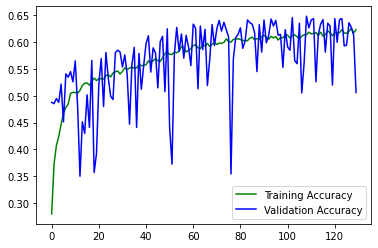

In [ ]:
plt.plot(history.history['accuracy'], color='green', label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label = 'Validation Accuracy')
plt.legend()

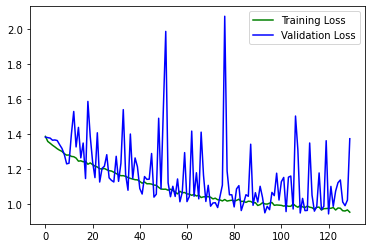

In [ ]:
plt.plot(history.history['loss'], color='green', label = 'Training Loss')
plt.plot(history.history['val_loss'], color='blue', label = 'Validation Loss')
plt.legend()

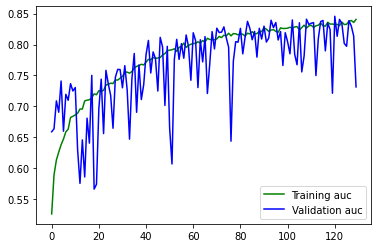

In [ ]:
plt.plot(history.history['auc'], color='green', label = 'Training auc')
plt.plot(history.history['val_auc'], color='blue', label = 'Validation auc')
plt.legend()

* The validation loss and accuracy are very unstable.

* At about Epoch=90, the trend of the validtion accuracy is about to go down. 

* At about Epoch=90, the trend of the validtion loss is about to go up. 

* The model at about Epoch=90 started overfitting，and the heighest accuracy is about 65%

### 5.5 Load Model

In [ ]:
# load weights of the best model save from the training above
export_path = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/best_vgg16.hdf5'
model1.load_weights(export_path)
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14713536  
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

### 5.6 Make Predition on the Validation Set Using Vgg16

In [ ]:
# Generate the Image Data for the Classifier
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_set = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='image_class', 
    shuffle=False,
    target_size=(224,224),
    batch_size=1,
    color_mode='grayscale',
    class_mode='categorical')

Found 1211 validated image filenames belonging to 4 classes.


In [ ]:
#Make Prediction
predictions1 = model1.predict(validation_set)

In [ ]:
#Conver the numeric labels back to string
class_indx = {v:k for k,v in validation_set.class_indices.items()}
y_pred1 = np.array([class_indx[i] for i in np.argmax(predictions1, axis=1)])
y_true1 = np.array([class_indx[j] for j in validation_set.classes])

Text(0.5, 1.0, 'Non Pretrained Vgg16 Confusion Matrix')

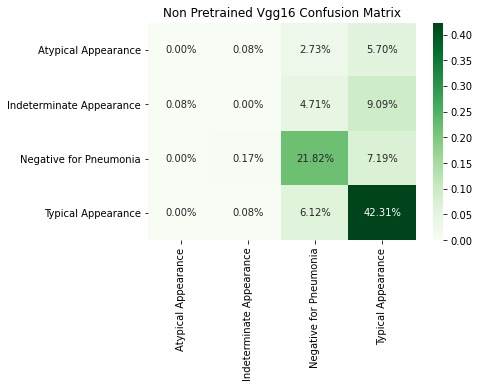

In [ ]:
#plot the confusuin matrix
labels = list(validation_set.class_indices.keys())
matrix = confusion_matrix(y_true=y_true1,y_pred=y_pred1)/len(predictions3)
df1 = pd.DataFrame(matrix,index=labels, columns=labels)
sns.heatmap(df1,cmap="Greens",annot=True,fmt='.2%')
plt.title('Non Pretrained Vgg16 Confusion Matrix')

In [ ]:
#print the classification report
print('Non Pretrained Vgg16')
print('-----------------------------------------------------------------')
print(classification_report(y_true1, y_pred1))

Non Pretrained Vgg16
-----------------------------------------------------------------
                          precision    recall  f1-score   support

     Atypical Appearance       0.00      0.00      0.00       103
Indeterminate Appearance       0.00      0.00      0.00       168
  Negative for Pneumonia       0.62      0.75      0.68       353
      Typical Appearance       0.66      0.87      0.75       587

                accuracy                           0.64      1211
               macro avg       0.32      0.41      0.36      1211
            weighted avg       0.50      0.64      0.56      1211



* The model cannot detect class 'Atypical Appearance' and 'Indeterminate Appearance'
* The accuracy is 64%, which is very low
* About 64% of the images are calssified as 'Typical Appearance', but only 42.3% of them are correct
* About 34% of the images are classified as 'Negative for Pneumonia', only 21.82% of them are correct.

## 6 Resnet50 Model

### 6.1 Image Data Generation for Resnet50 

In [ ]:
batch_size = 64

# rescale each pixel into range [0,1]
train_datagen = ImageDataGenerator(
                             rescale=1./255,
                             rotation_range = 15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             #zoom_range=[0.5,1.0],
                             #brightness_range=[0.5,1.0],
                             horizontal_flip = True
                             )
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image_path',
    y_col='image_class',
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    seed=1)

validation_set = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='image_class', 
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    #subset='validation',
    seed=1)

Found 4843 validated image filenames belonging to 4 classes.
Found 1211 validated image filenames belonging to 4 classes.


In [ ]:
train_set[0][0][0].shape

(224, 224, 1)

### 6.2 Create the Non Pretrained Resnet50 Model

In [ ]:
resnet50 = ResNet50(include_top=False, 
                    weights=None,
                    input_shape=(224,224,1))
#resnet50.summary()

# Adding some layers to the end of the resnet50 model

model2 = Sequential([
    resnet50,
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    #Dense(512, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    #Dense(256, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    #Dense(128, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    Flatten(),
    Dense(4,activation='softmax')
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14713536  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

### 6.3 Train the Resnt50 Model

In [ ]:
model2.compile(
    optimizer = optimizers.Adam(learning_rate=0.00003), 
    loss = 'categorical_crossentropy',               
    metrics=[AUC(name = 'auc'), 'accuracy'])

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/'

callback = ModelCheckpoint(filepath=checkpoint_filepath + 'best_resnet50.hdf5',
                           save_weights_only=True,
                           monitor='val_auc',
                           mode='max',
                           save_best_only=True)

history = model.fit(train_set, 
                    validation_data = validation_set, 
                    steps_per_epoch=math.ceil(train_set.n//train_set.batch_size),
                    validation_steps=validation_set.n//validation_set.batch_size,
                    epochs = 100,
                    callbacks=[callback])

Epoch 1/100
75/75 [==============================] - 234s 3s/step - loss: 1.8015 - auc: 0.6226 - accuracy: 0.3580 - val_loss: 1.3875 - val_auc: 0.4923 - val_accuracy: 0.1389
Epoch 2/100
75/75 [==============================] - 221s 3s/step - loss: 1.6721 - auc: 0.6411 - accuracy: 0.3836 - val_loss: 1.3279 - val_auc: 0.6019 - val_accuracy: 0.4852
Epoch 3/100
75/75 [==============================] - 220s 3s/step - loss: 1.6503 - auc: 0.6417 - accuracy: 0.3785 - val_loss: 1.3932 - val_auc: 0.6035 - val_accuracy: 0.4861
Epoch 4/100
75/75 [==============================] - 220s 3s/step - loss: 1.5981 - auc: 0.6525 - accuracy: 0.3949 - val_loss: 1.4303 - val_auc: 0.6469 - val_accuracy: 0.4835
Epoch 5/100
75/75 [==============================] - 220s 3s/step - loss: 1.5997 - auc: 0.6526 - accuracy: 0.3869 - val_loss: 1.3821 - val_auc: 0.6559 - val_accuracy: 0.4635
Epoch 6/100
75/75 [==============================] - 221s 3s/step - loss: 1.5615 - auc: 0.6586 - accuracy: 0.3946 - val_loss: 1.43

### 6.4 Plot the Training Result of Resnet50 Model

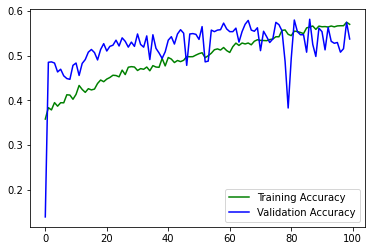

In [ ]:
plt.plot(history.history['accuracy'], color='green', label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label = 'Validation Accuracy')
plt.legend()

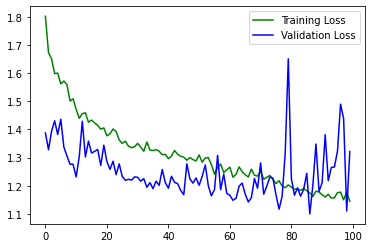

In [ ]:
plt.plot(history.history['loss'], color='green', label = 'Training Loss')
plt.plot(history.history['val_loss'], color='blue', label = 'Validation Loss')
plt.legend()

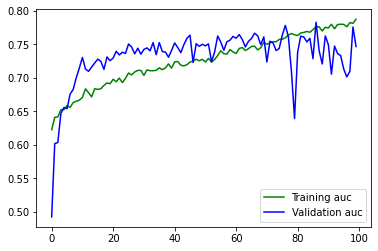

In [ ]:
plt.plot(history.history['auc'], color='green', label = 'Training auc')
plt.plot(history.history['val_auc'], color='blue', label = 'Validation auc')
plt.legend()

* According to the plot above, the trend of training and validation loss are going down before epoch=80.
* The results are more stable than the results of non-pre-trained Vgg16 model. 
* The vlidation accuracy is not as good as the Vgg16 overall. The highest accuracy is 0.5816, with the auc value 0.7832.

### 6.5 Load Model

In [ ]:
# load weights of the best model save from the training above
export_path = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/best_resnet50.hdf5'
model2.load_weights(export_path)
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23581440  
_________________________________________________________________
dense_12 (Dense)             (None, 7, 7, 512)         1049088   
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
dense_13 (Dense)             (None, 7, 7, 256)         131328    
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 256)        

### 6.6 Make Predition on the Validation Set Using Resnet50

In [ ]:
# Generate the Image Data for the Classifier

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_set = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='image_class', 
    shuffle=False,
    target_size=(224,224),
    batch_size=1,
    color_mode='grayscale',
    class_mode='categorical',
    #subset='validation',
    seed=1)

Found 1211 validated image filenames belonging to 4 classes.


In [ ]:
predictions2 = model2.predict(validation_set)

In [ ]:
y_pred2 = np.array([class_indx[i] for i in np.argmax(predictions2, axis=1)])
y_true2 = np.array([class_indx[j] for j in validation_set.classes])

Text(0.5, 1.0, 'Non Pretrained Resnet50')

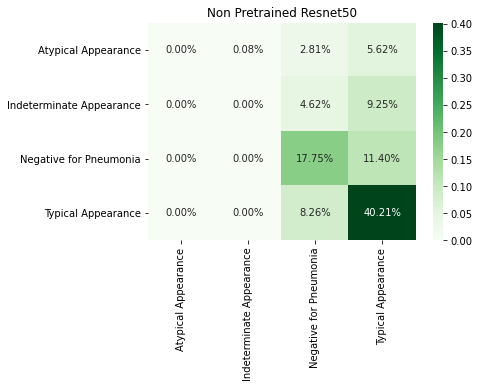

In [ ]:
labels = list(validation_set.class_indices.keys())
matrix = confusion_matrix(y_true=y_true2,y_pred=y_pred2)/len(predictions3)
df2 = pd.DataFrame(matrix,index=labels, columns=labels)
sns.heatmap(df2,cmap="Greens",annot=True,fmt='.2%')
plt.title('Non Pretrained Resnet50')

In [ ]:
print('Non Pretrained Resnet50')
print('-----------------------------------------------------------------')
print(classification_report(y_true2, y_pred2))

Non Pretrained Resnet50
-----------------------------------------------------------------
                          precision    recall  f1-score   support

     Atypical Appearance       0.00      0.00      0.00       103
Indeterminate Appearance       0.00      0.00      0.00       168
  Negative for Pneumonia       0.53      0.61      0.57       353
      Typical Appearance       0.60      0.83      0.70       587

                accuracy                           0.58      1211
               macro avg       0.28      0.36      0.32      1211
            weighted avg       0.45      0.58      0.50      1211



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* The results of this model is even worse than the pervious one. 
* It also cannot predict 'Atypical Appearance' and 'Indeterminate Appearance'

## 7 Pre-trained Vgg16 Model

### 7.1 Image Data Generation for Resnet50 

In [ ]:
BATCH_SIZE = 64

dataflow_kwargs = dict(
                       target_size=(224, 224),
                       batch_size=BATCH_SIZE,
                       interpolation="lanczos"
                      )


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.9999)

valid_generator = valid_datagen.flow_from_dataframe(dataframe=test,
                                                    x_col='image_path',
                                                    y_col='image_class',
                                                    subset="validation",
                                                    shuffle=True,
                                                    seed=42,
                                                    **dataflow_kwargs)

train_datagen = ImageDataGenerator(rotation_range=40,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    x_col='image_path',
                                                    y_col='image_class',
                                                    subset="training",
                                                    shuffle=True,
                                                    seed=42,
                                                    **dataflow_kwargs)

print('classes :', train_generator.class_indices)

Found 1210 validated image filenames belonging to 4 classes.
Found 4843 validated image filenames belonging to 4 classes.
classes : {'Atypical Appearance': 0, 'Indeterminate Appearance': 1, 'Negative for Pneumonia': 2, 'Typical Appearance': 3}


### 7.2 Create the Vgg16 Model and Load the Weights


In [ ]:
base_model = VGG16(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")


for layer in base_model.layers:
    layer.trainable=False

In [ ]:
#Adding layers to the end of the vgg16 moedl
model3=Sequential()
model3.add(base_model)
model3.add(Dropout(0.5))
model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dense(2048,kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1024,kernel_initializer='he_uniform'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4,activation='softmax'))

### 7.3 Train the Model

In [ ]:
filepath = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/'

checkpoint = ModelCheckpoint(filepath+'best_weights.hdf5', 
                             monitor = 'val_auc', 
                             mode='max', 
                             save_best_only=True, 
                             verbose = 1)

callback_list = [checkpoint] 

In [ ]:
OPT = Adam(lr=0.0005)

model3.compile(loss='categorical_crossentropy',
              metrics=[AUC(name = 'auc'), 'accuracy'],
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_history=model3.fit(train_generator,
                        validation_data=valid_generator,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
76/76 [==============================] - 6370s 84s/step - loss: 1.5906 - auc: 0.7052 - accuracy: 0.4609 - val_loss: 2.0301 - val_auc: 0.7166 - val_accuracy: 0.4752

Epoch 00001: val_auc improved from -inf to 0.71661, saving model to /content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/best_weights.hdf5
Epoch 2/50
76/76 [==============================] - 761s 10s/step - loss: 1.4122 - auc: 0.7355 - accuracy: 0.4887 - val_loss: 1.4264 - val_auc: 0.7966 - val_accuracy: 0.6066

Epoch 00002: val_auc improved from 0.71661 to 0.79660, saving model to /content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/best_weights.hdf5
Epoch 3/50
76/76 [==============================] - 758s 10s/step - loss: 1.3190 - auc: 0.7518 - accuracy: 0.5127 - val_loss: 1.3178 - val_auc: 0.7638 - val_accuracy: 0.5504

Epoch 00003: val_auc did not improve from 0.79660
Epoch 4/50
76/76 [==============================] - 754s 10s/step - loss: 1.2830 

### 7.4 Plot the Training Result of the Pre-trained Vgg16 Model

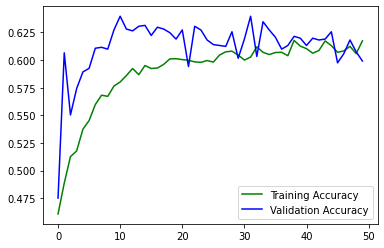

In [ ]:
plt.plot(model_history.history['accuracy'], color='green', label = 'Training Accuracy')
plt.plot(model_history.history['val_accuracy'], color='blue', label = 'Validation Accuracy')
plt.legend()

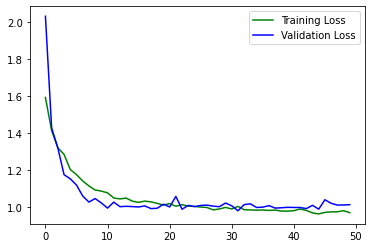

In [ ]:
plt.plot(model_history.history['loss'], color='green', label = 'Training Loss')
plt.plot(model_history.history['val_loss'], color='blue', label = 'Validation Loss')
plt.legend()

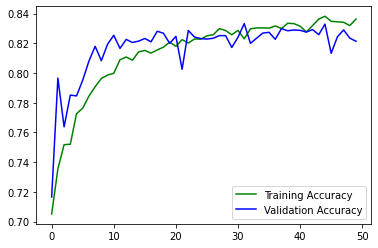

In [ ]:
plt.plot(model_history.history['auc'], color='green', label = 'Training AUC')
plt.plot(model_history.history['val_auc'], color='blue', label = 'Validation AUC')
plt.legend()

### 7.5 Load the Vgg16 Model

In [ ]:
model_path = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/best_weights.hdf5'
model3.load_weights(model_path)
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 25088)             100352    
_________________________________________________________________
dense_21 (Dense)             (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_16 (Batc (None, 2048)              8192      
_________________________________________________________________
activation_2 (Activation)    (None, 2048)             

### 7.6 Make Prediction on Validation Set Using pre-tain Vgg16 model

In [ ]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.9999)

valid_generator = valid_datagen.flow_from_dataframe(dataframe=test,
                                                    x_col='image_path',
                                                    y_col='image_class',
                                                    subset="validation",
                                                    shuffle=False,
                                                    seed=42,
                                                    target_size=(224, 224),
                                                    batch_size=1)

Found 1210 validated image filenames belonging to 4 classes.


In [ ]:
predictions3 = model3.predict(valid_generator)

In [ ]:
y_pred3 = np.array([class_indx[i] for i in np.argmax(predictions3, axis=1)])
y_true3 = np.array([class_indx[j] for j in valid_generator.classes])

Text(0.5, 1.0, 'Pretrained Vgg16 Confusion Matrix')

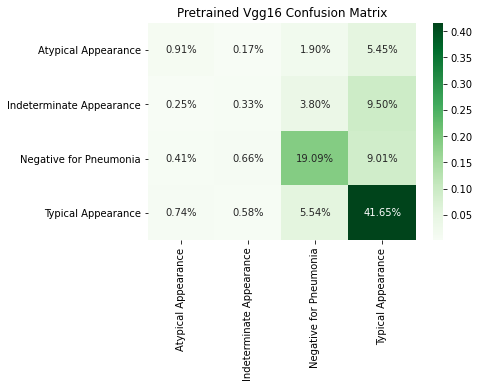

In [ ]:
labels = list(valid_generator.class_indices.keys())
matrix = confusion_matrix(y_true=y_true3,y_pred=y_pred3)/len(predictions3)
df = pd.DataFrame(matrix,index=labels, columns=labels)
sns.heatmap(df,cmap="Greens",annot=True,fmt='.2%')
plt.title('Pretrained Vgg16 Confusion Matrix')

In [ ]:
print('Pretrained Vgg16')
print('-----------------------------------------------------------------')
print(classification_report(y_true3, y_pred3))

Pretrained Vgg16
-----------------------------------------------------------------
                          precision    recall  f1-score   support

     Atypical Appearance       0.39      0.11      0.17       102
Indeterminate Appearance       0.19      0.02      0.04       168
  Negative for Pneumonia       0.63      0.65      0.64       353
      Typical Appearance       0.63      0.86      0.73       587

                accuracy                           0.62      1210
               macro avg       0.46      0.41      0.40      1210
            weighted avg       0.55      0.62      0.56      1210



* The accuracy of this model is lower than the first one, but it work better on predictiong 'Atypical Appearance'and Indeterminate Appearance.
* The accuracy on predicting 'Negative for Pneumonia' and 'Typical Appearance' is not as good as the first one. 
* Even though the model predicted 'Atypical Appearance'and 'Indeterminate Appearance'better than the pervious two models, more 'Negative for Pneumonia' and 'Typical Appearance' images are calssified as 'Atypical Appearance'and 'Indeterminate Appearance'.

## Model Comparision

In [ ]:
models = ['Non pretrained Vgg16', 'Pretrained Vgg16', 'Non Pretrained Resnet50']
ys = [(y_true1,y_pred1),(y_true2,y_pred2),(y_true3,y_pred3)] 
for i, name in enumerate(models):
  print(name)
  print('-----------------------------------------------------------------')
  print(classification_report(ys[i][0], ys[i][1]))

Non pretrained Vgg16
-----------------------------------------------------------------
                          precision    recall  f1-score   support

     Atypical Appearance       0.00      0.00      0.00       103
Indeterminate Appearance       0.00      0.00      0.00       168
  Negative for Pneumonia       0.62      0.75      0.68       353
      Typical Appearance       0.66      0.87      0.75       587

                accuracy                           0.64      1211
               macro avg       0.32      0.41      0.36      1211
            weighted avg       0.50      0.64      0.56      1211

Pretrained Vgg16
-----------------------------------------------------------------
                          precision    recall  f1-score   support

     Atypical Appearance       0.00      0.00      0.00       103
Indeterminate Appearance       0.00      0.00      0.00       168
  Negative for Pneumonia       0.53      0.61      0.57       353
      Typical Appearance       0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* All models can not calssify the images well. The accuracies of the model are quite low, the highest accuracy is 64%. 
* The models cannot predict class 'Atypical Appearance' and 'Indeterminate Appearance' 